#Imports

In [275]:
!pip install sklearn-som
!pip install minisom

  Created wheel for minisom: filename=MiniSom-2.3.0-py3-none-any.whl size=9018 sha256=9e7ce4d3a134f3058a3bad931100bc7b4d6a4c86e6a56fecbf0104fb5898a8e8
  Stored in directory: /root/.cache/pip/wheels/d4/ca/4a/488772b0399fec45ff53132ed14c948dec4b30deee3a532f80
Successfully built minisom


In [277]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from minisom import MiniSom
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, silhouette_samples, silhouette_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.cluster import pair_confusion_matrix
from sklearn_som.som import SOM
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram

In [3]:
import numpy as np

def rbf(x1, x2, gamma = None):
        '''
        RBF: Radial basis function or guassian kernel
        ----------------------------------------------
        :param: x1: NxD transposed feature space
        :param: x2: NxD feature space
        :param: gamma: 1/2(sigma-square)
        :return type: kernel(Gram) matrix
        '''
        if not gamma:
            gamma = 1
        else:
            gamma = gamma
        if x1.ndim == 1 and x2.ndim == 1:
            return np.exp(-gamma * np.linalg.norm(x1 - x2))
        elif (x1.ndim > 1 and x2.ndim == 1) or (x1.ndim == 1 and x2.ndim > 1):
            return np.exp(-gamma * np.linalg.norm(x1 - x2, axis = 1))
        elif x1.ndim > 1 and x2.ndim > 1:
            return np.exp(-gamma * np.linalg.norm(x1[:, np.newaxis] - x2[np.newaxis, :], axis = 2))

class kkMeans:
    def __init__(self, k = None, gamma = None, d = None):
        '''
        :param: k: number of clusters
        :param: kernel
        
        '''
        super().__init__()
        if not gamma:
            gamma = 5
            self.gamma = gamma
        else:
            self.gamma = gamma
        if not d:
            d = 3
            self.d = d
        else:
            self.d = d
        if not k:
            k = 2
            self.k = k
        else:
            self.k = k
        return
    
    def kernelize(self, x1, x2):
        return rbf(x1, x2, gamma = self.gamma)
    
    #compute suqared kernel distance
    def distance(self, kappa):
        self.dist_w = np.zeros(self.k)
        c_k_init = np.ones(kappa.shape[0])
        for ii in range(self.k):
            self.c_k_indices = self.clusters == ii
            self.c_k = np.sum(c_k_init[self.c_k_indices])
            self.c_k_squared = np.square(self.c_k)
            self.kappa_ii = kappa[self.c_k_indices][:, self.c_k_indices]
            self.distance_ii[:, ii] += np.sum(self.kappa_ii)/self.c_k_squared - 2*\
                                    np.sum(kappa[:, self.c_k_indices], axis = 1)/self.c_k
        return self.distance_ii
           
    #fit and return cluster labels
    def fit_predict(self, X, iteration = None, halt = None):
        '''
        :param: X: NxD Feature
        :param: iteration: 100
        :param: tolerance: 1e-3 default
        
        '''
        if not halt:
            halt = 1e-3
            self.halt = halt
        else:
            self.halt = halt
        if not iteration:
            iteration = 100
            self.iteration = iteration
        else:
            self.iteration = iteration
        self.X = X
        N, D = X.shape
        self.distance_ii = np.zeros((N, self.k))
        self.kx = self.kernelize(self.X, self.X)
        self.clusters = np.random.randint(self.k, size = N)
        '''iterate by checking to see if new and previous cluster
        labels are similar. If they are, algorithm converges and halts..
        '''
        for ii in range(self.iteration):
            #compute distance
            self.distance_k = self.distance(self.kx)
            self.prev_clusters = self.clusters
            self.clusters = self.distance_k.argmin(axis=1)
            if 1 - float(np.sum((self.clusters - self.prev_clusters) == 0)) / N < self.halt:
                break
        return self

    def rand_index_score(self, clusters, classes):
        '''Compute the RandIndex
        :param: Clusters: Cluster labels
        :param: classses: Actual class
        :returntype: float
        '''
        from scipy.special import comb
        tp_fp = comb(np.bincount(clusters), 2).sum()
        tp_fn = comb(np.bincount(classes), 2).sum()
        A = np.c_[(clusters, classes)]
        tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
                 for i in set(clusters))
        fp = tp_fp - tp
        fn = tp_fn - tp
        tn = comb(len(A), 2) - tp - fp - fn
        self.randindex = (tp + tn) / (tp + fp + fn + tn)
        return self.randindex

In [212]:
data_2d_10c = pd.read_csv("./2d-10c.dat", header=None, sep=' ')[3:]
data_iris = pd.read_csv("./iris.csv", header=None)
data_long = pd.read_csv("./long.data", header=None, sep=' ')
data_order2_3clust = pd.read_csv("./order2-3clust.csv", header=None)
data_smile = pd.read_csv("./smile.csv", header=None)
data_square = pd.read_csv("./square.data", header=None, sep=' ')
data_heart = pd.read_csv("./heart.csv")

scaler = preprocessing.StandardScaler()

data_2d_10c_X = data_2d_10c.to_numpy()[:, :-1]
data_2d_10c_y = data_2d_10c.to_numpy()[:, -1]
data_iris_X = data_iris.to_numpy()[:, :-1]
data_iris_y = data_iris.to_numpy()[:, -1]
data_long_X = data_long.to_numpy()[:, :-1]
data_long_y = data_long.to_numpy()[:, -1]
data_order2_3clust_X = data_order2_3clust.to_numpy()[:, :-1]
data_order2_3clust_y = data_order2_3clust.to_numpy()[:, -1]
data_smile_X = data_smile.to_numpy()[:, :-1]
data_smile_y = data_smile.to_numpy()[:, -1]
data_square_X = data_square.to_numpy()[:, :-1]
data_square_y = data_square.to_numpy()[:, -1]
data_heart_X = data_heart.to_numpy()[:, :-1]
data_heart_y = data_heart.to_numpy()[:, -1]

data_2d_10c_X_normalized = scaler.fit_transform(data_2d_10c_X)
data_iris_X_normalized = scaler.fit_transform(data_iris_X)
data_long_X_normalized = scaler.fit_transform(data_long_X)
data_order2_3clust_X_normalized = scaler.fit_transform(data_order2_3clust_X)
data_smile_X_normalized = scaler.fit_transform(data_smile_X)
data_square_X_normalized = scaler.fit_transform(data_square_X)
data_heart_X_normalized = scaler.fit_transform(data_heart_X)

#Dataset 2d-10c

In [30]:
data_X = data_2d_10c_X
data_X_normalized = data_2d_10c_X_normalized
data_y = data_2d_10c_y
n_components = 10
n_dimensions = 2

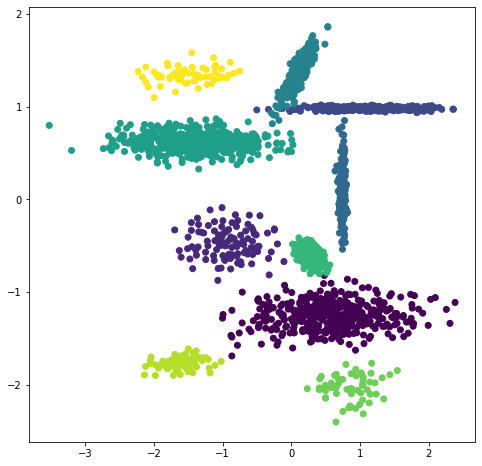

In [21]:
plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=data_y)
plt.show()

##Single linkage

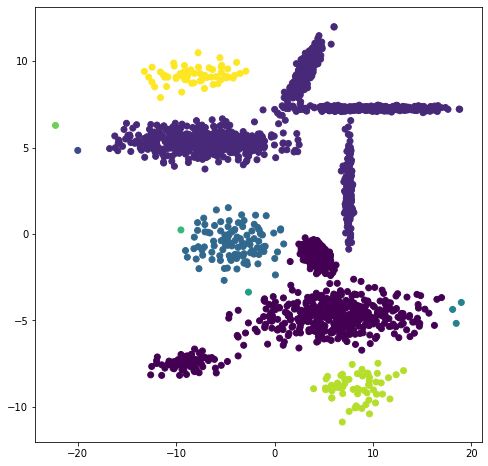

Adjusted rand index:  0.36306139186145114


In [31]:
clustering = AgglomerativeClustering(linkage='single', n_clusters=n_components).fit(data_X_normalized)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Complete linkage

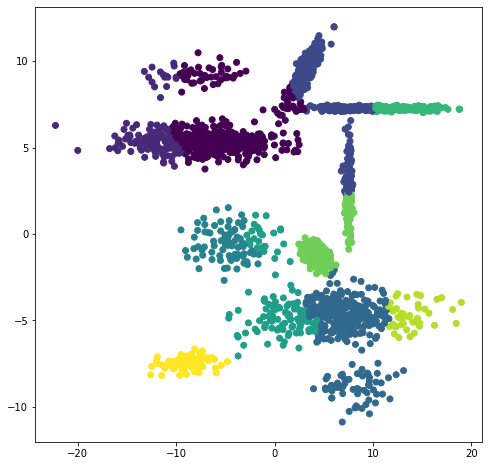

Adjusted rand index:  0.5788494654191659


In [32]:
clustering = AgglomerativeClustering(linkage='complete', n_clusters=n_components).fit(data_X_normalized)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Average linkage

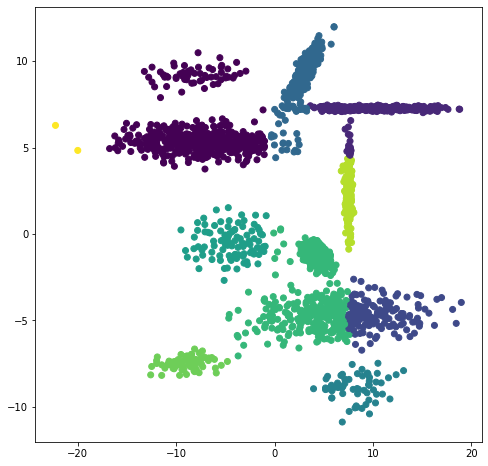

Adjusted rand index:  0.7282505385885099


In [33]:
clustering = AgglomerativeClustering(linkage='average', n_clusters=n_components).fit(data_X_normalized)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Ward variance

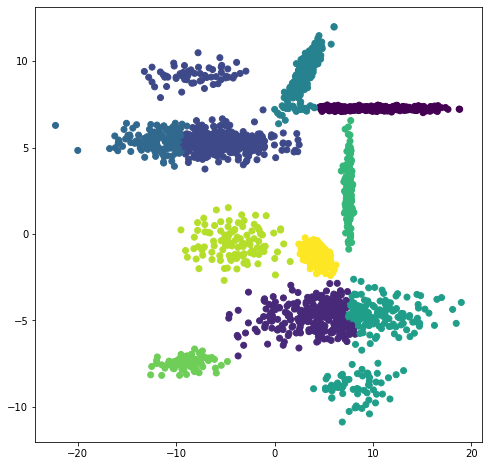

Adjusted rand index:  0.8170271521894713


In [34]:
clustering = AgglomerativeClustering(linkage='ward', n_clusters=n_components).fit(data_X_normalized)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##DBSCAN

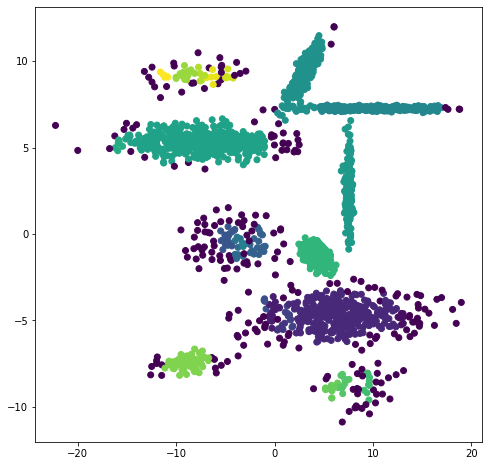

Adjusted rand index:  0.8676342236364002


In [35]:
clustering = DBSCAN().fit(data_X)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##KMeans

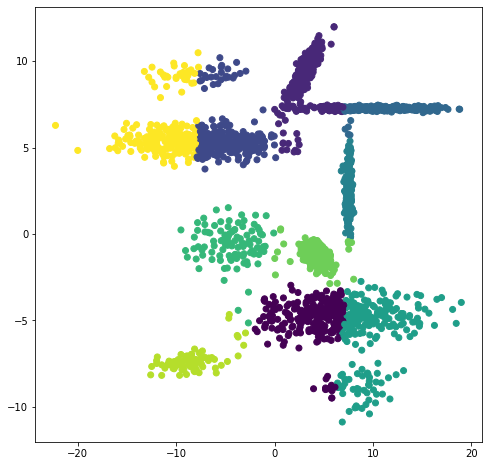

Adjusted rand index:  0.7337304054637764


In [36]:
kmeans = KMeans(n_clusters=n_components, random_state=0).fit(data_X_normalized)
predictions = kmeans.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Kernelized KMeans

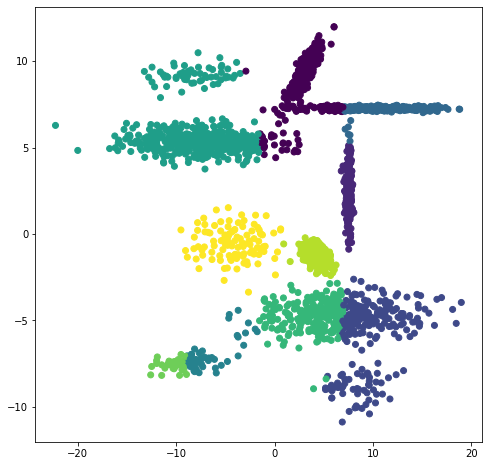

Adjusted rand index:  0.7973648273143169


In [53]:
kkmeans = kkMeans(k = n_components, gamma=0.95).fit_predict(data_X_normalized)
predictions = kkmeans.clusters

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Expectation-Maximization (EM) clustering

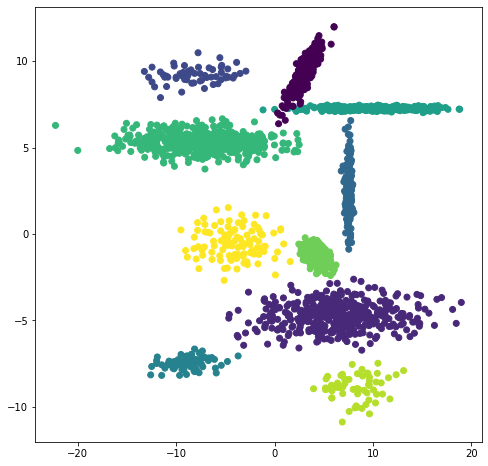

Adjusted rand index:  0.9982089084808446


In [55]:
gm = GaussianMixture(n_components=n_components, random_state=0).fit(data_X)
predictions = gm.predict(data_X)

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Self - organizing maps (SOM)

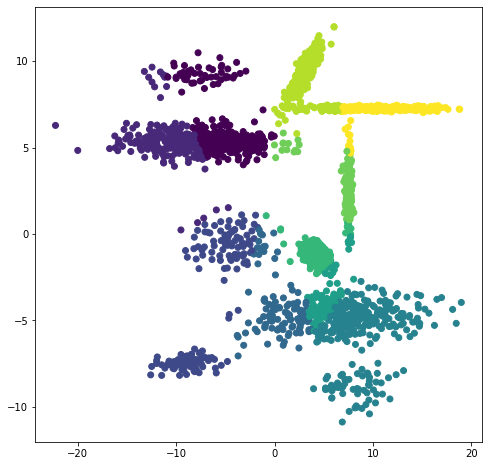

Adjusted rand index:  0.6853519594673922


In [57]:
som = SOM(m=n_components, n=1, dim=n_dimensions)
som.fit(data_X)
predictions = som.predict(data_X)

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

For this dataset EM produces the best result with a 99% score for the adjusted rand index

The Average Linkage, DBSCAN, Kernelized KMeans and EM algorithms classified the data more closely to the true labels, with EM being the best among them.

#Dataset iris

In [259]:
data_X = data_iris_X
data_X_normalized = data_iris_X_normalized
data_y = data_iris_y
n_components = 3
n_dimensions = 4

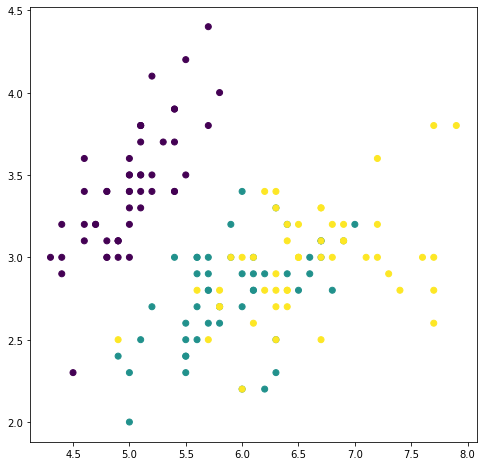

In [59]:
plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=data_y)
plt.show()

##Single linkage

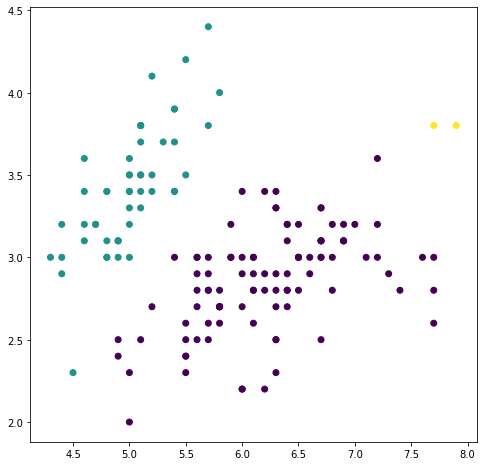

Adjusted rand index:  0.5637510205230709


In [61]:
clustering = AgglomerativeClustering(linkage='single', n_clusters=n_components).fit(data_X)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Complete linkage

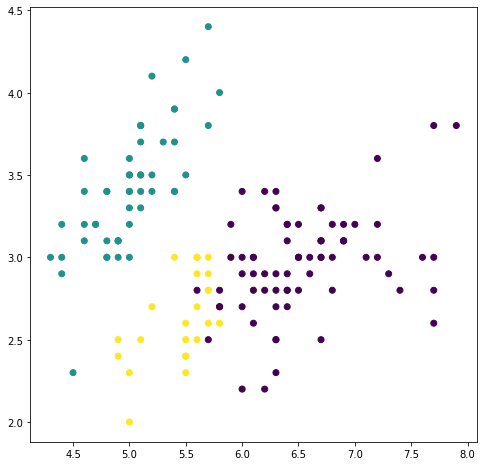

Adjusted rand index:  0.6422512518362898


In [63]:
clustering = AgglomerativeClustering(linkage='complete', n_clusters=n_components).fit(data_X)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Average linkage

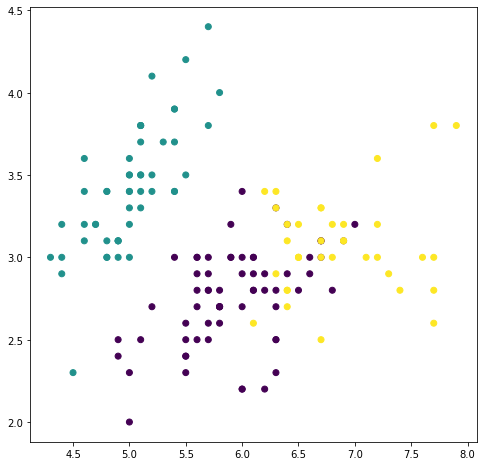

Adjusted rand index:  0.7591987071071522


In [65]:
clustering = AgglomerativeClustering(linkage='average', n_clusters=n_components).fit(data_X)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Ward variance

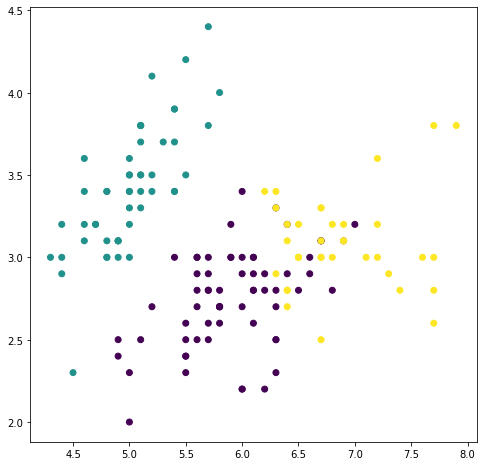

Adjusted rand index:  0.7311985567707746


In [67]:
clustering = AgglomerativeClustering(linkage='ward', n_clusters=n_components).fit(data_X)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##DBSCAN

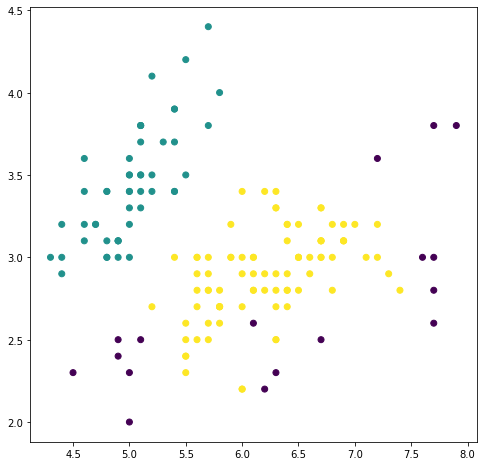

Adjusted rand index:  0.5206185241703302


In [69]:
clustering = DBSCAN().fit(data_X)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##KMeans

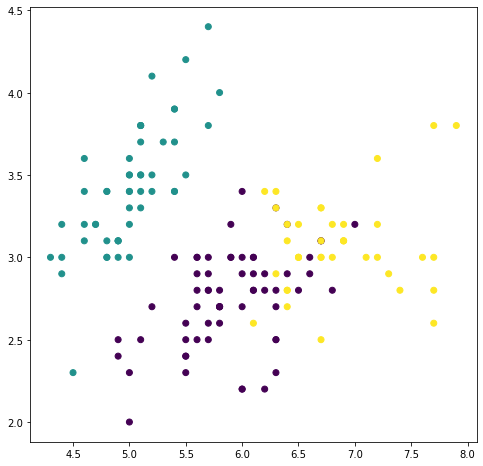

Adjusted rand index:  0.7302382722834697


In [71]:
kmeans = KMeans(n_clusters=n_components, random_state=0).fit(data_X)
predictions = kmeans.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Kernelized KMeans

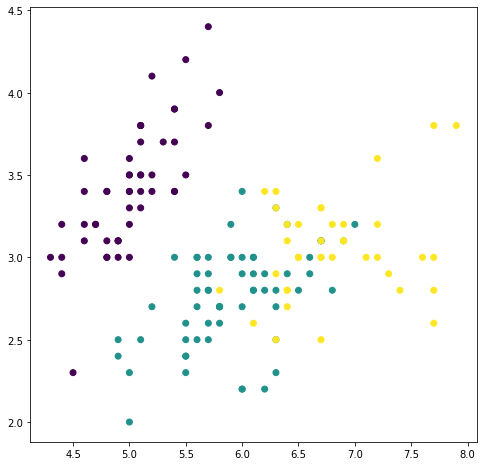

Adjusted rand index:  0.7726314170414115


In [82]:
kkmeans = kkMeans(k = n_components, gamma=0.21).fit_predict(data_X)
predictions = kkmeans.clusters

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Expectation-Maximization (EM) clustering

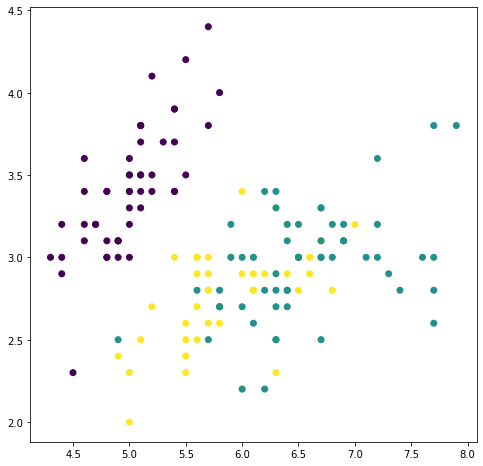

Adjusted rand index:  0.9038742317748124


In [84]:
gm = GaussianMixture(n_components=n_components, random_state=0).fit(data_X)
predictions = gm.predict(data_X)

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Self - organizing maps (SOM)

In [320]:
target = data_iris.iloc[: , -1].values
label_names = {0:'Iris Setosa', 1:'Iris Versicolour', 2:'Iris Virginica'}
data = data_iris[data_iris.columns[:-1]]

data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values

In [323]:
def plot_som_density(som, data):
  colors = ['C0', 'C1', 'C2']
  w_x, w_y = zip(*[som.winner(d) for d in data])
  w_x = np.array(w_x)
  w_y = np.array(w_y)

  plt.figure(figsize=(10, 9))
  plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
  plt.colorbar()

  for c in np.unique(target):
      idx_target = target==c
      plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                  w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                  s=50, c=colors[c-1], label=label_names[c])
  plt.legend(loc='center right')
  plt.grid()
  plt.show()

def plot_som_clusters(som, som_shape, data):
  winner_coordinates = np.array([som.winner(x) for x in data]).T
  cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

  for c in np.unique(cluster_index):
      plt.scatter(data[cluster_index == c, 0],
                  data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

  for centroid in som.get_weights():
      plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                  s=80, linewidths=35, color='k', label='centroid')
  plt.legend();

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.6320520283464257


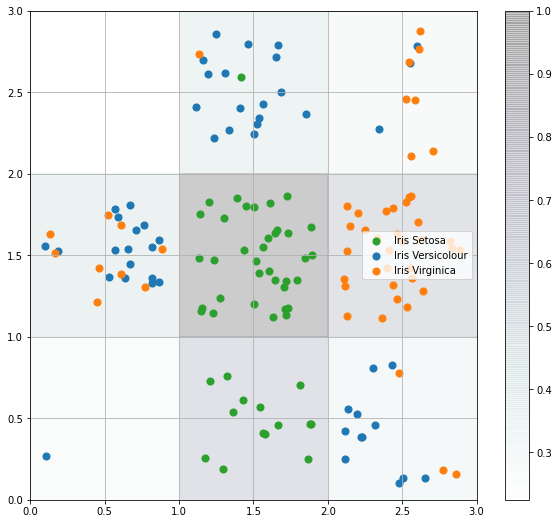

In [336]:
n_neurons = 3
m_neurons = 3
som = MiniSom(n_neurons, m_neurons, data.shape[1], sigma=0.1, learning_rate=.1, 
              neighborhood_function='gaussian', random_seed=0)

som.pca_weights_init(data)
som.train(data, 1000, verbose=True)

plot_som_density(som, data)

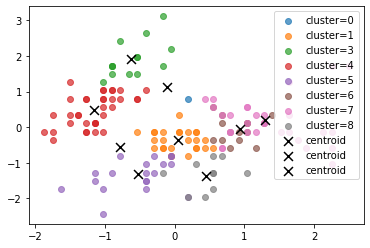

In [337]:
plot_som_clusters(som, (n_neurons, m_neurons), data)

In [342]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(som.distance_map().T)
predictions = kmeans.labels_
predictions

array([0, 1, 2], dtype=int32)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.5877990167743453


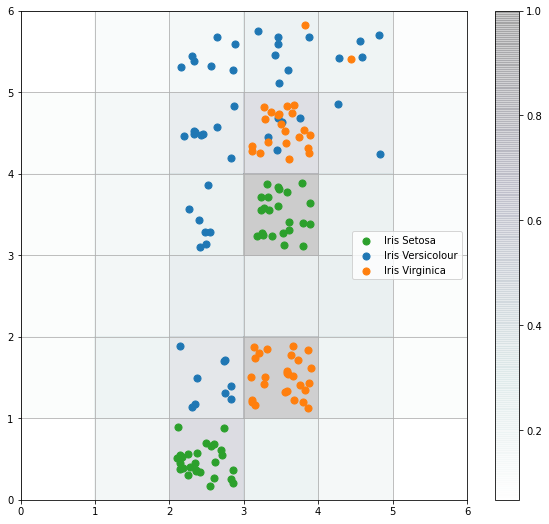

In [343]:
n_neurons = 6
m_neurons = 6
som = MiniSom(n_neurons, m_neurons, data.shape[1], sigma=0.1, learning_rate=.1, 
              neighborhood_function='gaussian', random_seed=0)

som.pca_weights_init(data)
som.train(data, 1000, verbose=True)

plot_som_density(som, data)

In [345]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(som.distance_map().T)
predictions = kmeans.labels_
predictions

array([0, 2, 1, 2, 1, 1], dtype=int32)

For this dataset EM produces the best result with a 90% score for the adjusted rand index

The Average Linkage, Ward variance, KMeans, Kernelized KMeans and EM algorithms classified the data more closely to the true labels, with EM being the best among them.

#Dataset long

In [87]:
data_X = data_long_X
data_X_normalized = data_long_X_normalized
data_y = data_long_y
n_components = 2
n_dimensions = 2

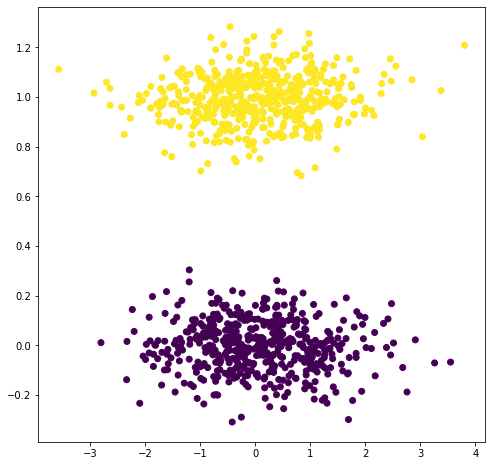

In [88]:
plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=data_y)
plt.show()

##Single linkage

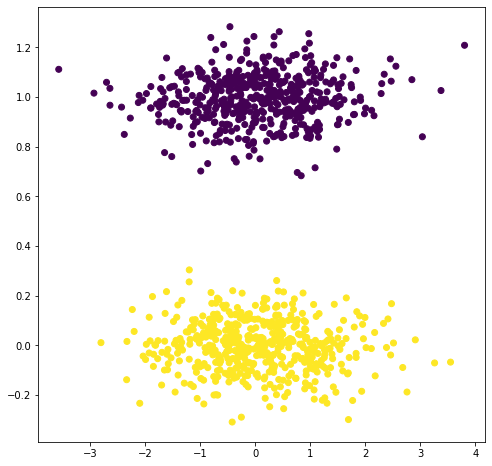

Adjusted rand index:  1.0


In [89]:
clustering = AgglomerativeClustering(linkage='single', n_clusters=n_components).fit(data_X_normalized)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Complete linkage

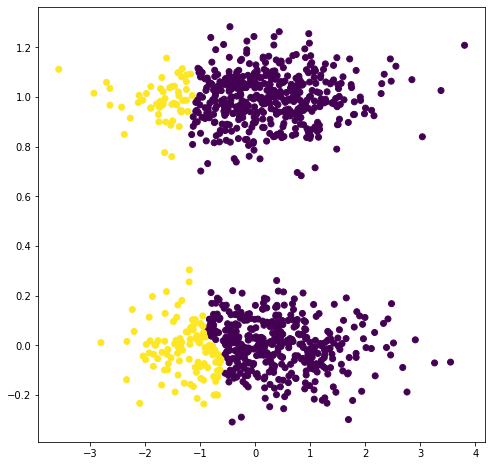

Adjusted rand index:  0.009450908594953032


In [92]:
clustering = AgglomerativeClustering(linkage='complete', n_clusters=n_components).fit(data_X_normalized)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Average linkage

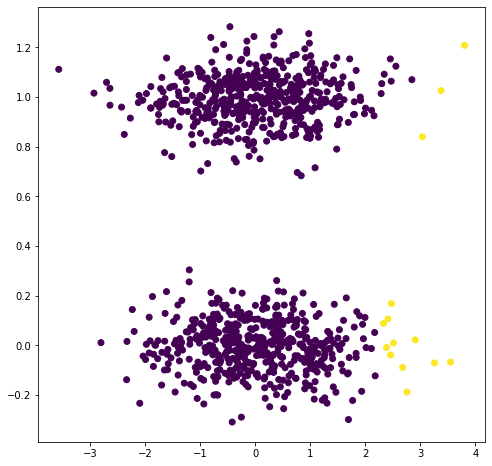

Adjusted rand index:  0.000200739823873989


In [93]:
clustering = AgglomerativeClustering(linkage='average', n_clusters=n_components).fit(data_X_normalized)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Ward variance

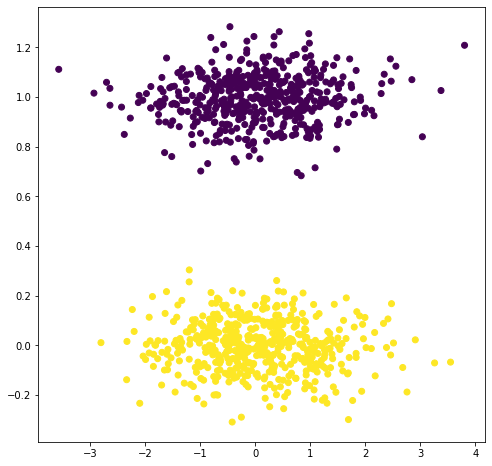

Adjusted rand index:  1.0


In [94]:
clustering = AgglomerativeClustering(linkage='ward', n_clusters=n_components).fit(data_X_normalized)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##DBSCAN

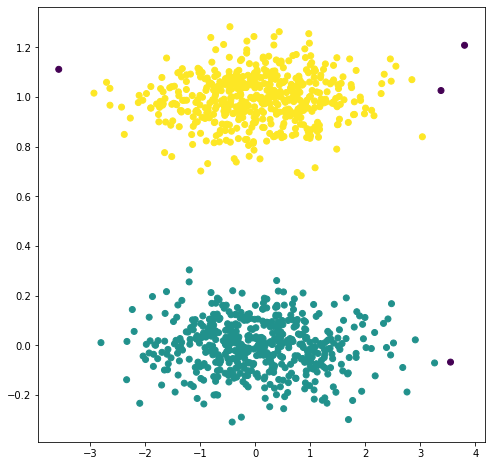

Adjusted rand index:  0.9920199484714934


In [96]:
clustering = DBSCAN().fit(data_X_normalized)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##KMeans

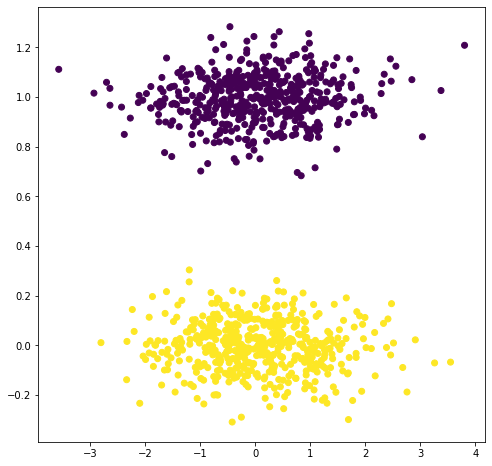

Adjusted rand index:  1.0


In [97]:
kmeans = KMeans(n_clusters=n_components, random_state=0).fit(data_X_normalized)
predictions = kmeans.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Kernelized KMeans

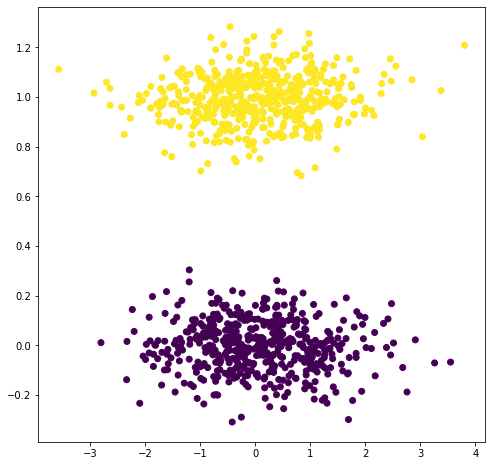

Adjusted rand index:  1.0


In [98]:
kkmeans = kkMeans(k = n_components, gamma=0.21).fit_predict(data_X_normalized)
predictions = kkmeans.clusters

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Expectation-Maximization (EM) clustering

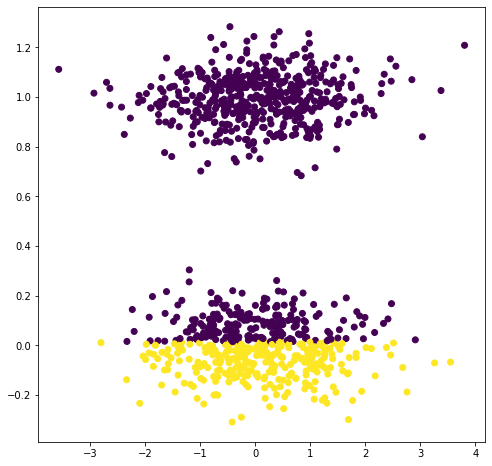

Adjusted rand index:  0.3243487253714217


In [101]:
gm = GaussianMixture(n_components=n_components, random_state=0).fit(data_X_normalized)
predictions = gm.predict(data_X)

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Self - organizing maps (SOM)

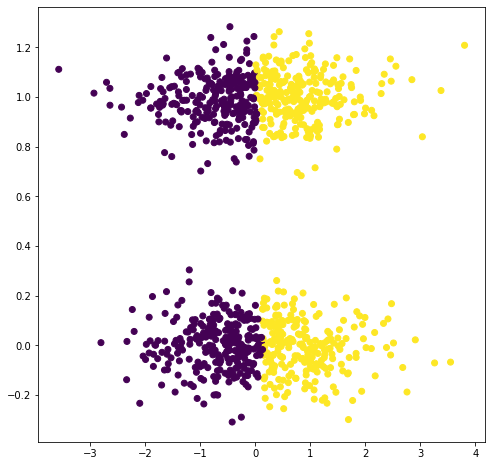

Adjusted rand index:  0.0006006246342288322


In [104]:
som = SOM(m=n_components, n=1, dim=n_dimensions)
som.fit(data_X)
predictions = som.predict(data_X_normalized)

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

For this dataset Kernelized KMeans produces the best result with a 76% score for the adjusted rand index

All the algorithms performed poorly, drawing a decision line through the middle or classifying all the points to the same class, except Kernelized KMeans which almost managed to classify all the points correctly.

#Dataset order2-3clust

In [105]:
data_X = data_order2_3clust_X
data_X_normalized = data_order2_3clust_X_normalized
data_y = data_order2_3clust_y
n_components = 3
n_dimensions = 2

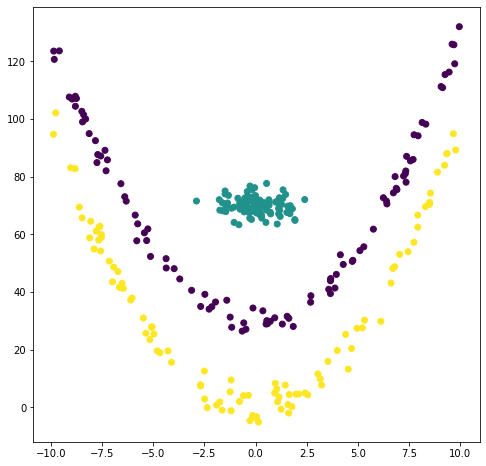

In [106]:
plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=data_y)
plt.show()

##Single linkage

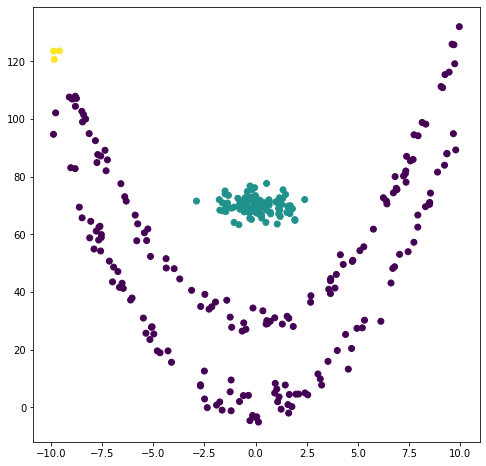

Adjusted rand index:  0.5664477456671392


In [107]:
clustering = AgglomerativeClustering(linkage='single', n_clusters=n_components).fit(data_X_normalized)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Complete linkage

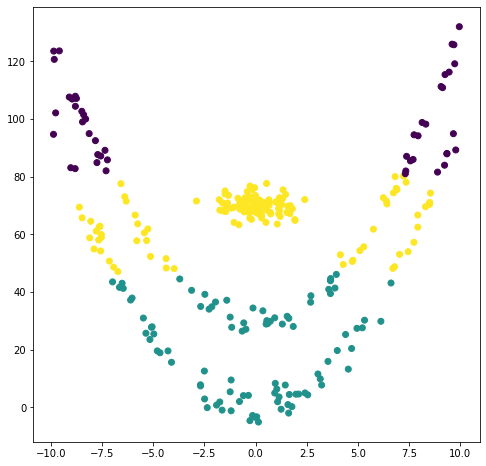

Adjusted rand index:  0.2924572720298255


In [109]:
clustering = AgglomerativeClustering(linkage='complete', n_clusters=n_components).fit(data_X)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Average linkage

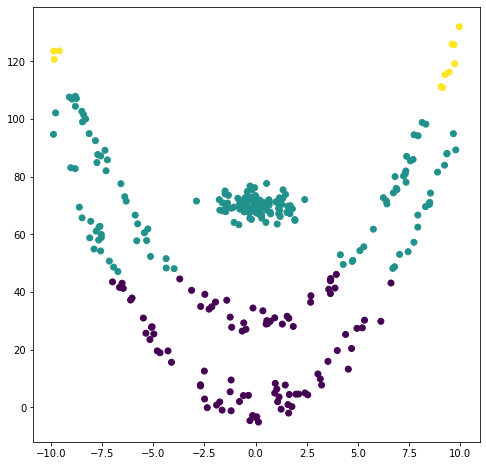

Adjusted rand index:  0.179046159897769


In [111]:
clustering = AgglomerativeClustering(linkage='average', n_clusters=n_components).fit(data_X)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Ward variance

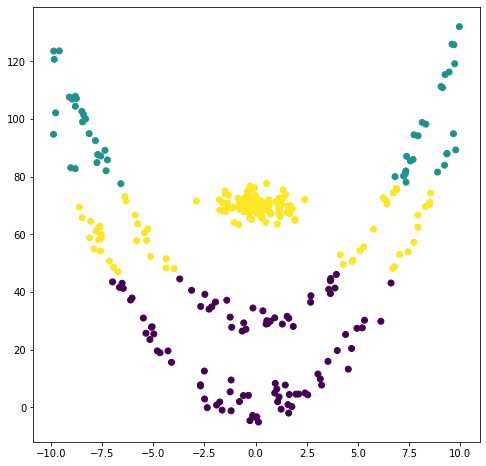

Adjusted rand index:  0.31276042541209537


In [113]:
clustering = AgglomerativeClustering(linkage='ward', n_clusters=n_components).fit(data_X)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##DBSCAN

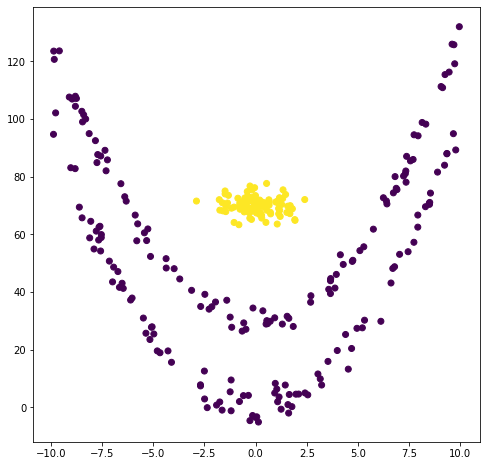

Adjusted rand index:  0.5697841726618705


In [114]:
clustering = DBSCAN().fit(data_X_normalized)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##KMeans

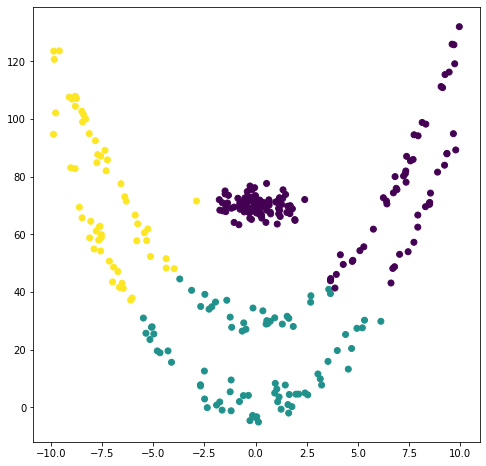

Adjusted rand index:  0.26661149956331426


In [115]:
kmeans = KMeans(n_clusters=n_components, random_state=0).fit(data_X_normalized)
predictions = kmeans.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Kernelized KMeans

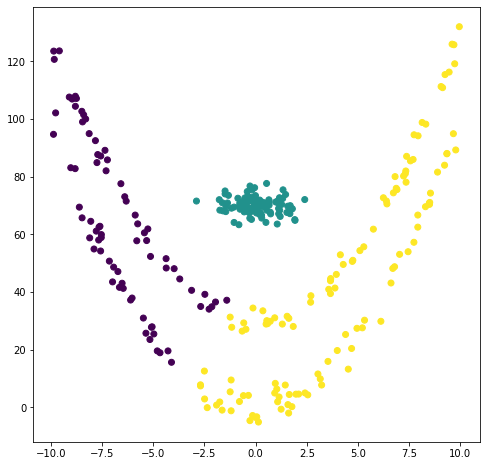

Adjusted rand index:  0.5035648207395133


In [133]:
kkmeans = kkMeans(k = n_components, gamma=1).fit_predict(data_X_normalized)
predictions = kkmeans.clusters

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Expectation-Maximization (EM) clustering

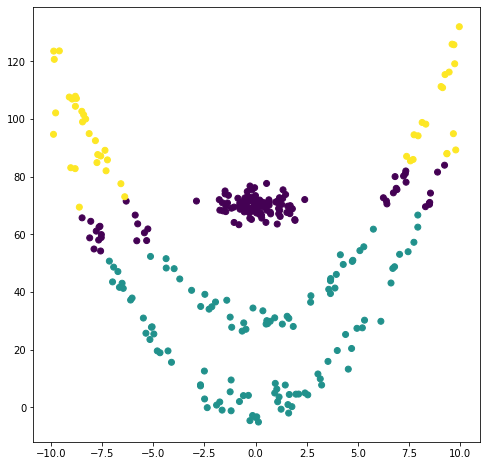

Adjusted rand index:  0.3808820562888344


In [135]:
gm = GaussianMixture(n_components=n_components, random_state=0).fit(data_X)
predictions = gm.predict(data_X)

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Self - organizing maps (SOM)

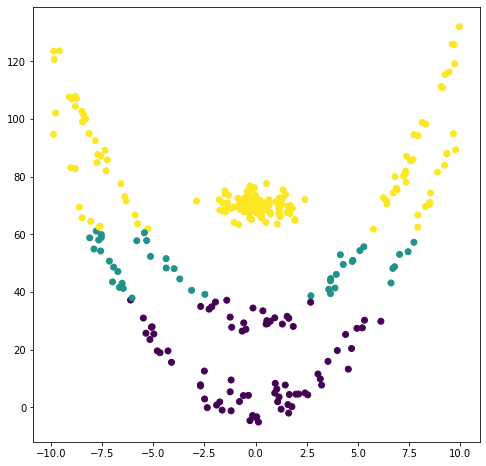

Adjusted rand index:  0.23130272100189786


In [137]:
som = SOM(m=n_components, n=1, dim=n_dimensions)
som.fit(data_X)
predictions = som.predict(data_X)

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

For this dataset Kernelized KMeans produces the best result with a 57% score for the adjusted rand index

All the algorithms performed quite poorly, with Ward variance, Kernelized KMeans and EM classifying the data more closely to the true labels.

#Dataset smile

In [138]:
data_X = data_smile_X
data_X_normalized = data_smile_X_normalized
data_y = data_smile_y
n_components = 4
n_dimensions = 2

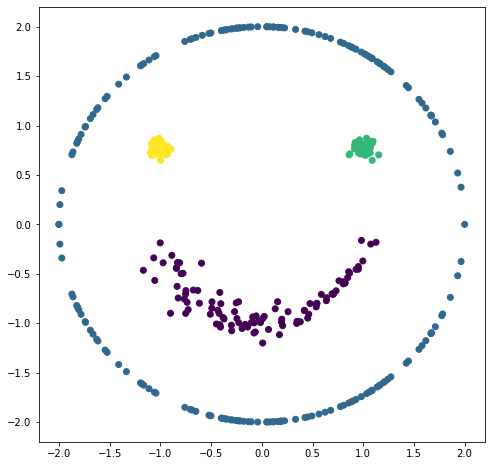

In [139]:
plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=data_y)
plt.show()

##Single linkage

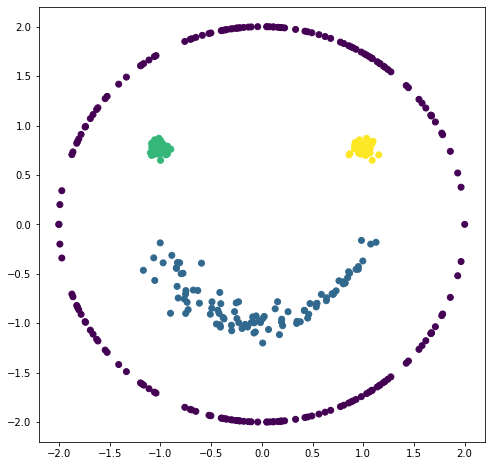

Adjusted rand index:  1.0


In [140]:
clustering = AgglomerativeClustering(linkage='single', n_clusters=n_components).fit(data_X_normalized)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Complete linkage

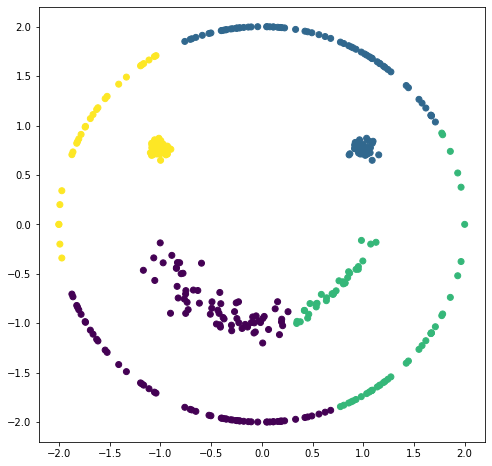

Adjusted rand index:  0.2038622216846395


In [141]:
clustering = AgglomerativeClustering(linkage='complete', n_clusters=n_components).fit(data_X_normalized)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Average linkage

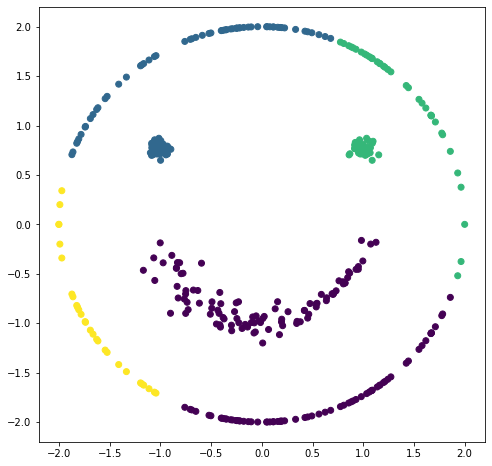

Adjusted rand index:  0.2458668674230882


In [144]:
clustering = AgglomerativeClustering(linkage='average', n_clusters=n_components).fit(data_X_normalized)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Ward variance

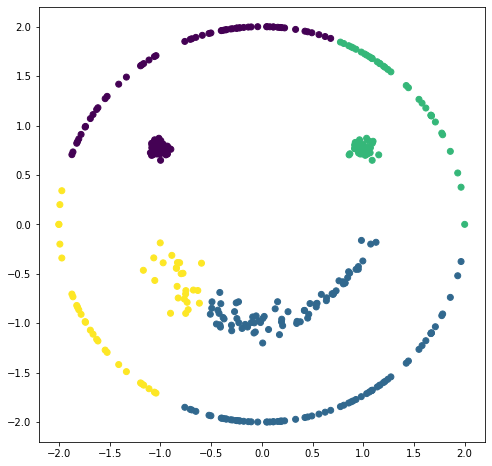

Adjusted rand index:  0.20414654709894994


In [146]:
clustering = AgglomerativeClustering(linkage='ward', n_clusters=n_components).fit(data_X)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##DBSCAN

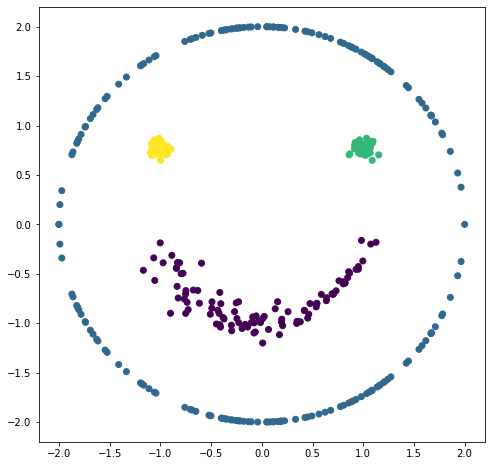

Adjusted rand index:  1.0


In [149]:
clustering = DBSCAN().fit(data_X_normalized)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##KMeans

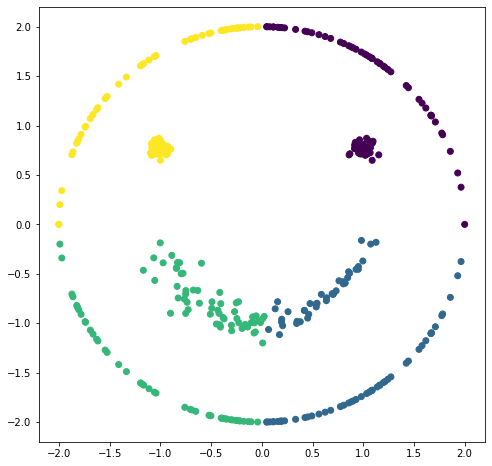

Adjusted rand index:  0.1851848367390459


In [151]:
kmeans = KMeans(n_clusters=n_components, random_state=0).fit(data_X)
predictions = kmeans.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Kernelized KMeans

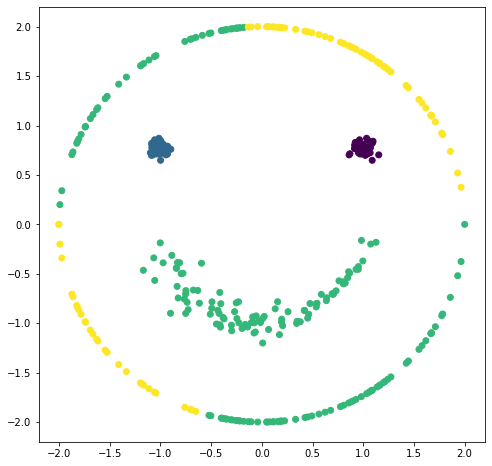

Adjusted rand index:  0.4165764595511294


In [166]:
kkmeans = kkMeans(k = n_components, gamma=3).fit_predict(data_X)
predictions = kkmeans.clusters

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Expectation-Maximization (EM) clustering

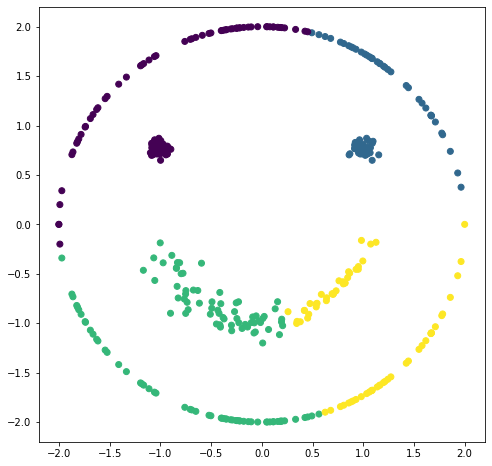

Adjusted rand index:  0.19229022827641973


In [168]:
gm = GaussianMixture(n_components=n_components, random_state=0).fit(data_X)
predictions = gm.predict(data_X)

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Self - organizing maps (SOM)

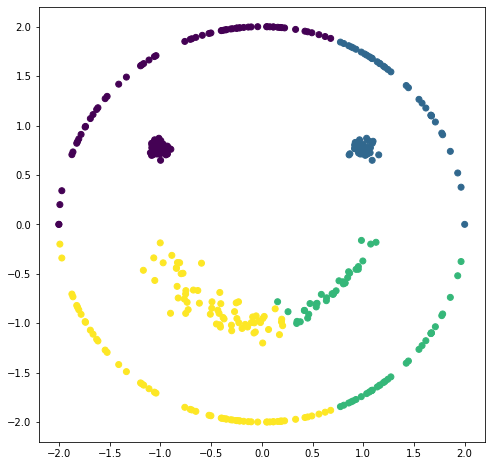

Adjusted rand index:  0.19568902092626914


In [170]:
som = SOM(m=n_components, n=1, dim=n_dimensions)
som.fit(data_X)
predictions = som.predict(data_X)

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

For this dataset Single Linkage produces the best result with a 100% score for the adjusted rand index.

The Single Linkage algorithm managed to correctly classify every point, with DBSCAN closely behind failing to classify only one point. The rest of the algorithms had bad results, with the exception of Kernelized KMeans which managed to achieve a 50% score for the adjusted rand index.

#Dataset square

In [171]:
data_X = data_square_X
data_X_normalized = data_square_X_normalized
data_y = data_square_y
n_components = 4
n_dimensions = 2

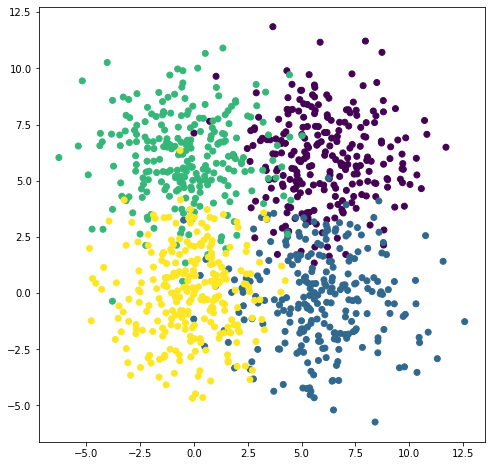

In [172]:
plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=data_y)
plt.show()

##Single linkage

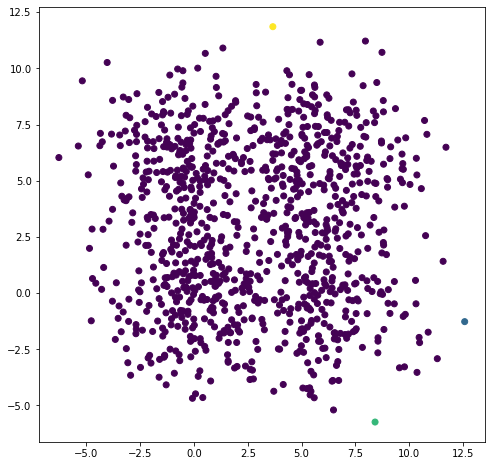

Adjusted rand index:  1.3507537471235578e-06


In [173]:
clustering = AgglomerativeClustering(linkage='single', n_clusters=n_components).fit(data_X_normalized)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Complete linkage

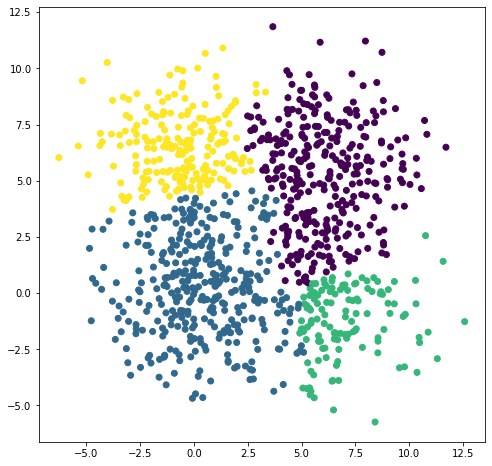

Adjusted rand index:  0.5504838884994412


In [175]:
clustering = AgglomerativeClustering(linkage='complete', n_clusters=n_components).fit(data_X)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Average linkage

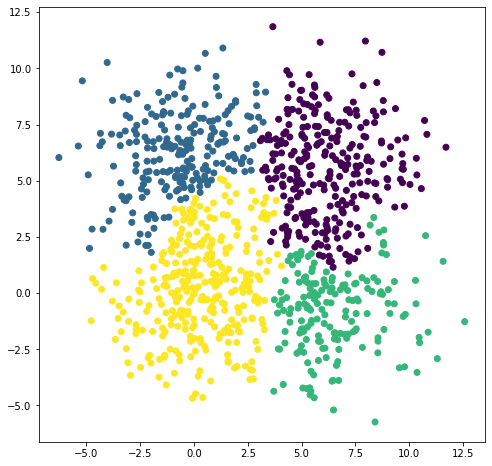

Adjusted rand index:  0.6037435609973467


In [177]:
clustering = AgglomerativeClustering(linkage='average', n_clusters=n_components).fit(data_X)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Ward variance

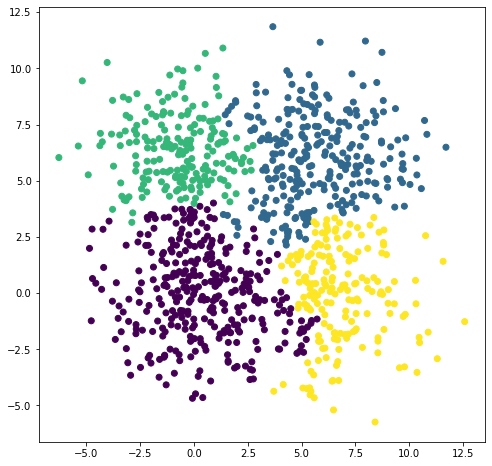

Adjusted rand index:  0.5946287023125574


In [178]:
clustering = AgglomerativeClustering(linkage='ward', n_clusters=n_components).fit(data_X_normalized)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##DBSCAN

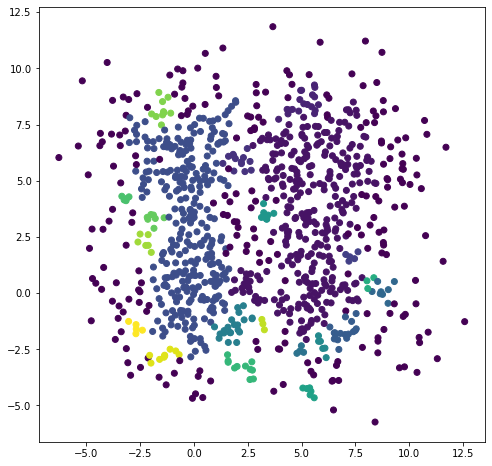

Adjusted rand index:  0.2042399389303871


In [180]:
clustering = DBSCAN().fit(data_X)
predictions = clustering.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##KMeans

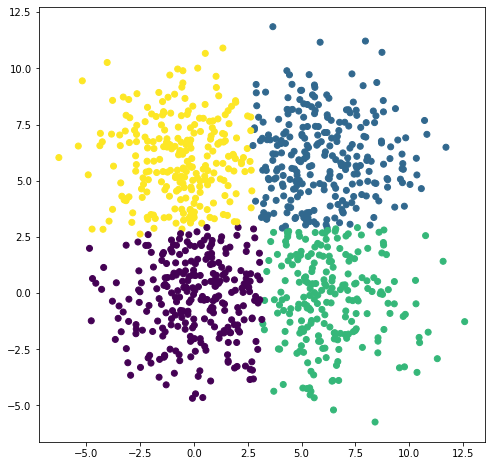

Adjusted rand index:  0.6931800370598739


In [182]:
kmeans = KMeans(n_clusters=n_components, random_state=0).fit(data_X)
predictions = kmeans.labels_

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Kernelized KMeans

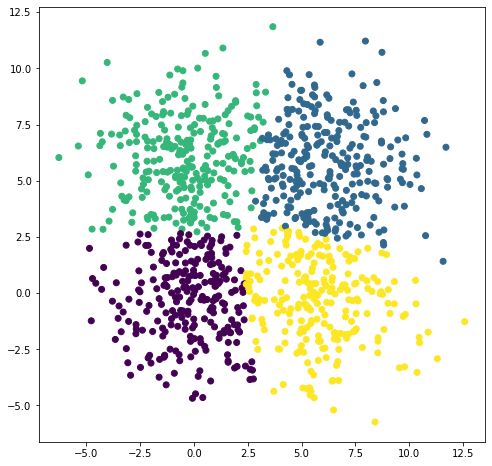

Adjusted rand index:  0.652793478052305


In [184]:
kkmeans = kkMeans(k = n_components, gamma=0.1).fit_predict(data_X)
predictions = kkmeans.clusters

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Expectation-Maximization (EM) clustering

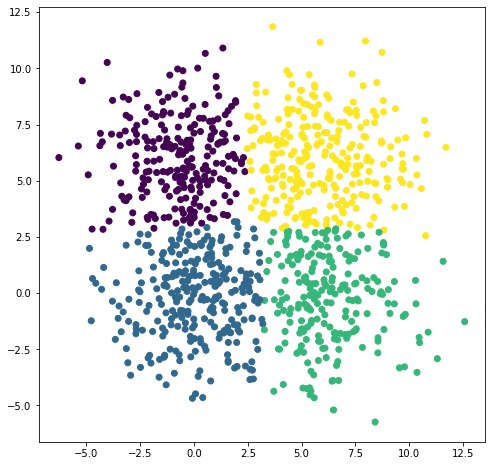

Adjusted rand index:  0.6843772646953642


In [186]:
gm = GaussianMixture(n_components=n_components, random_state=0).fit(data_X)
predictions = gm.predict(data_X)

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

##Self - organizing maps (SOM)

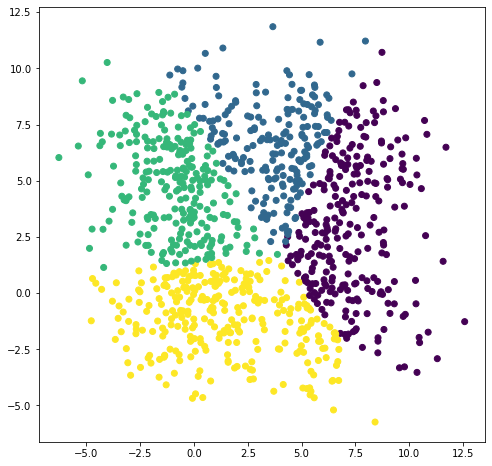

Adjusted rand index:  0.37546057562697427


In [188]:
som = SOM(m=n_components, n=1, dim=n_dimensions)
som.fit(data_X)
predictions = som.predict(data_X)

plt.figure(figsize=(8, 8))
plt.scatter(data_X[:, 0], data_X[:, 1], c=predictions)
plt.show()

print("Adjusted rand index: ", adjusted_rand_score(data_y, predictions))

For this dataset KMeans produces the best result with a 69% score for the adjusted rand index.

The Kernelized KMeans and EM algorithms also managed to get a 68% score for the adjusted rand index. The dataset contains a lot of noise which makes it hard for the algorithms to identify clusters, especially for those where we have to specify the number of clusters beforehand.

#Determining the optimal number of clusters on iris

##KMeans

For n_clusters = 2 The average silhouette_score is : 0.6808136202936816
For n_clusters = 3 The average silhouette_score is : 0.5525919445499757
For n_clusters = 4 The average silhouette_score is : 0.4978256901095472
For n_clusters = 5 The average silhouette_score is : 0.49285559183161204
For n_clusters = 6 The average silhouette_score is : 0.36820569682713084
For n_clusters = 7 The average silhouette_score is : 0.3600597997328459
For n_clusters = 8 The average silhouette_score is : 0.3538815380353622
For n_clusters = 9 The average silhouette_score is : 0.3407785831583716
For n_clusters = 10 The average silhouette_score is : 0.33380799465469013


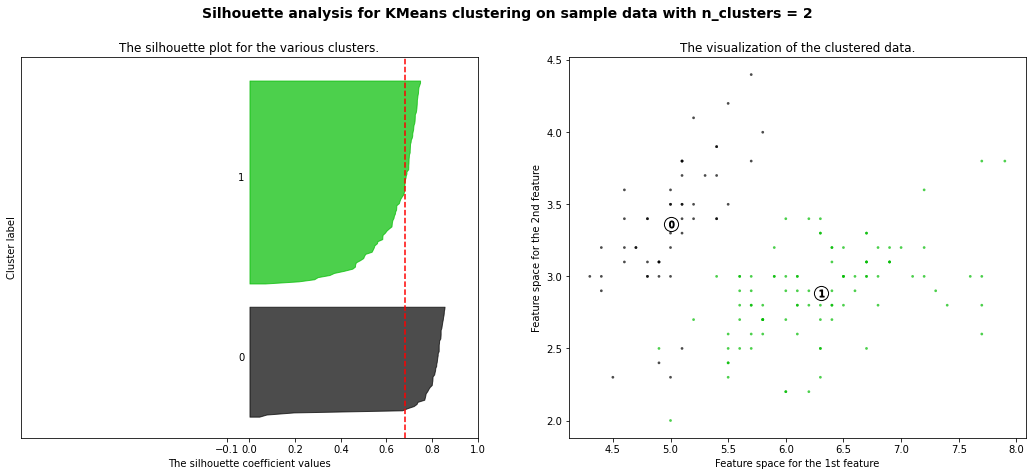

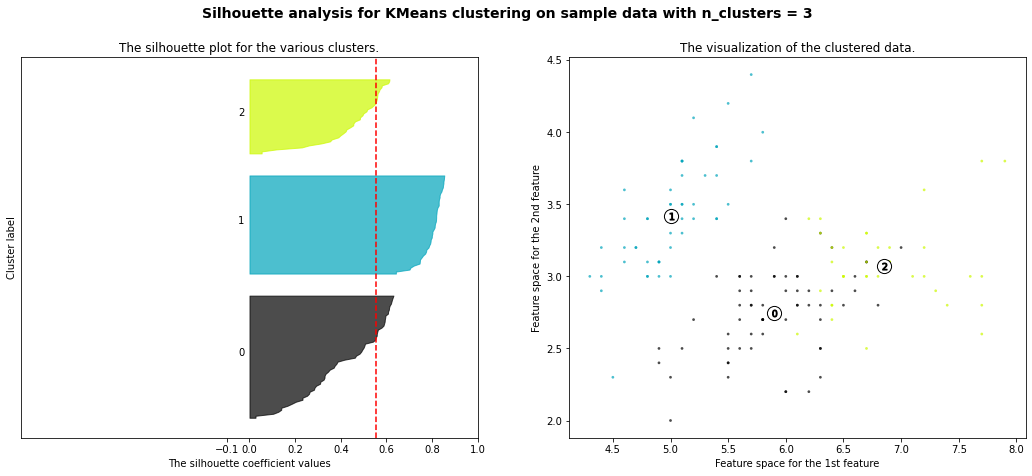

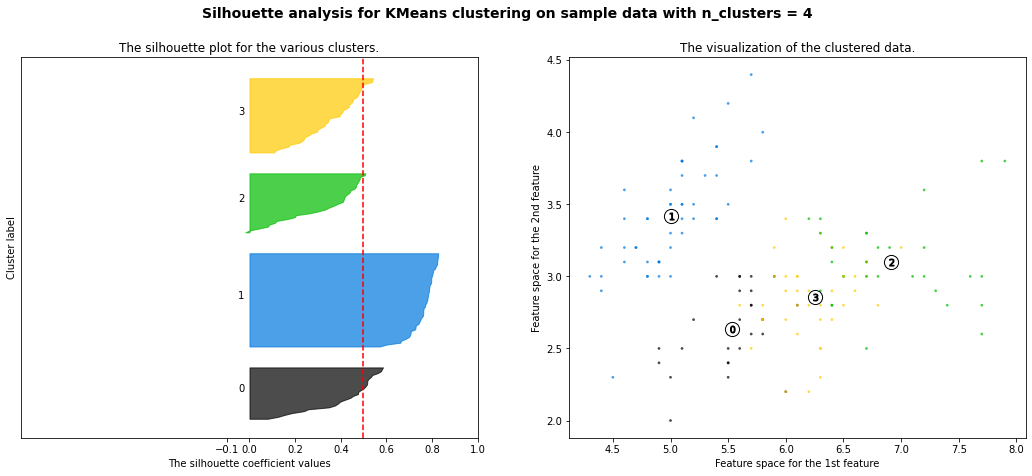

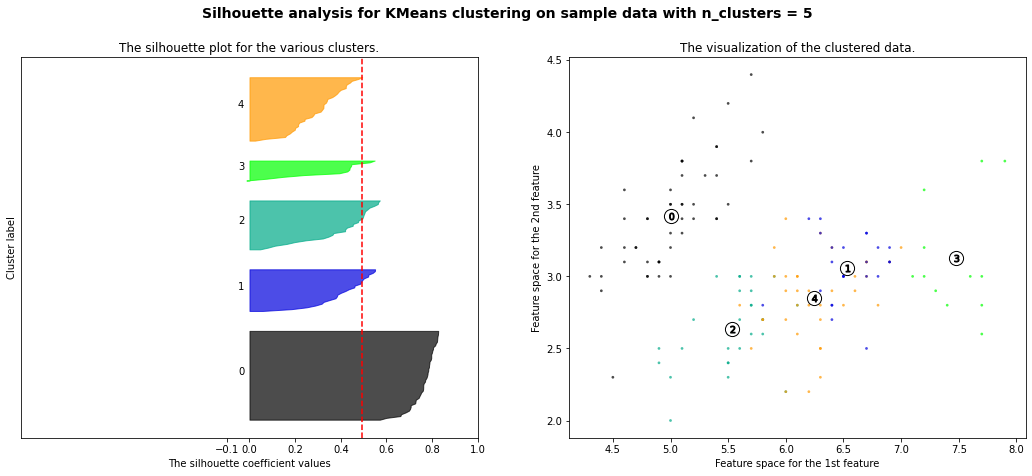

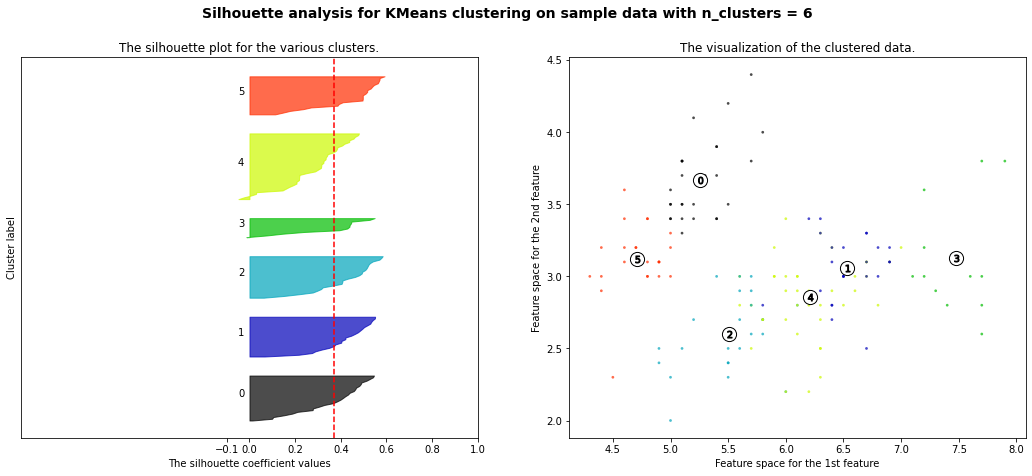

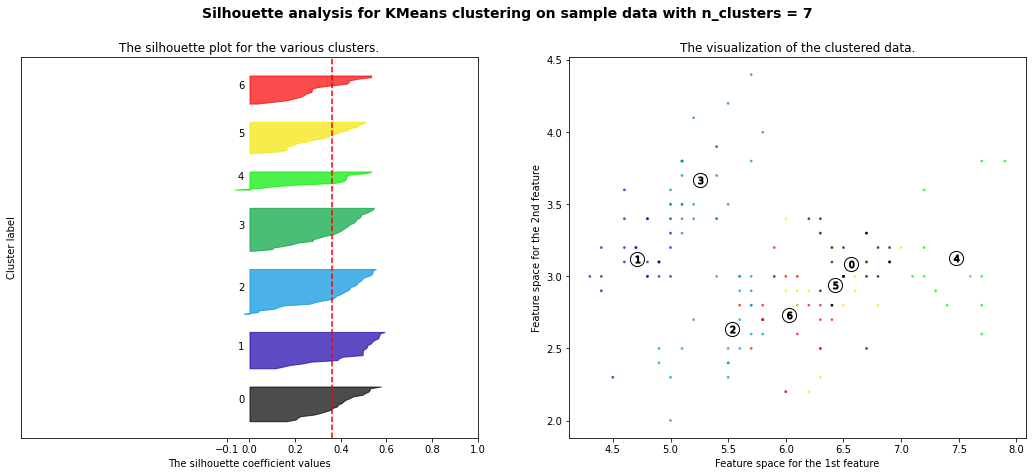

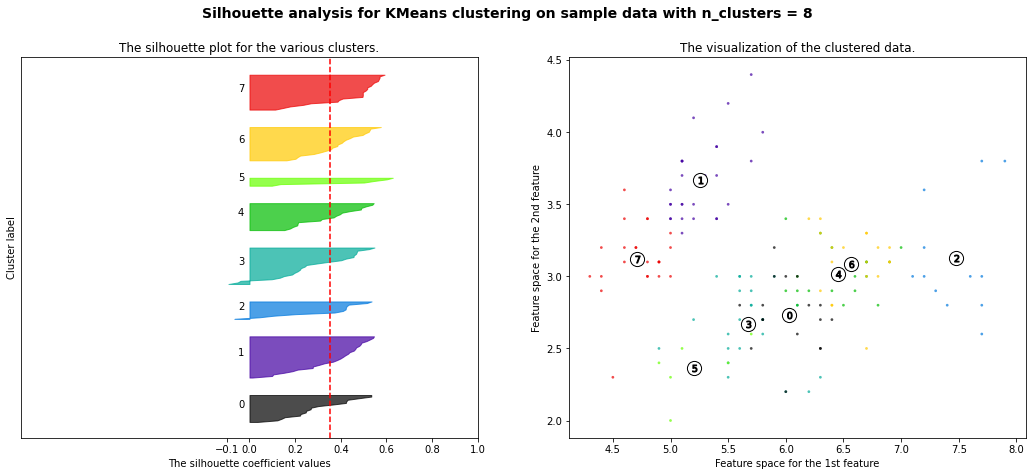

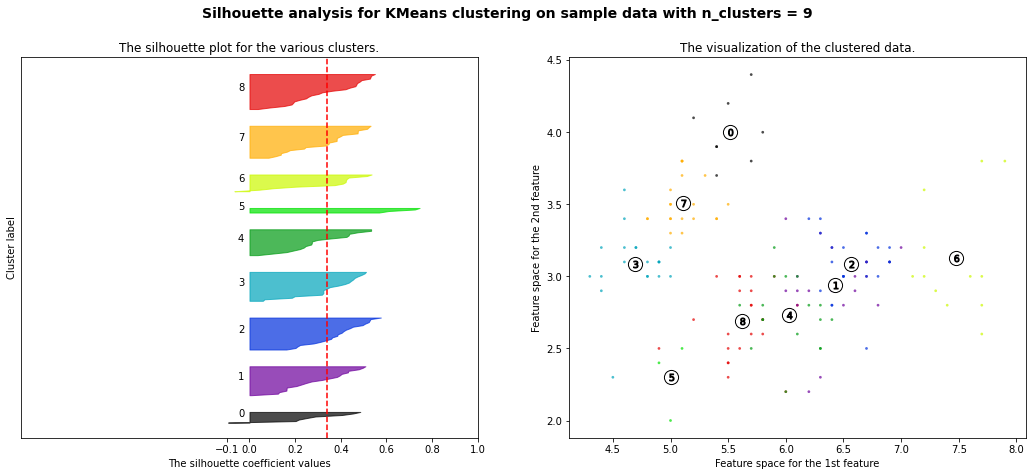

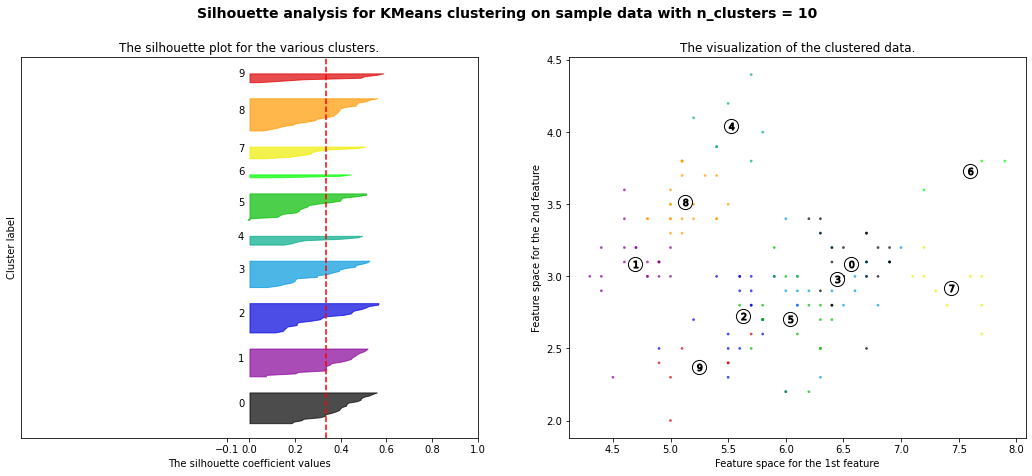

In [201]:
for n_clusters in range(2, 11):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(data_iris_X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(data_iris_X)

    silhouette_avg = silhouette_score(data_iris_X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(data_iris_X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        data_iris_X[:, 0],
        data_iris_X[:, 1],
        marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()



##Intra-class variances

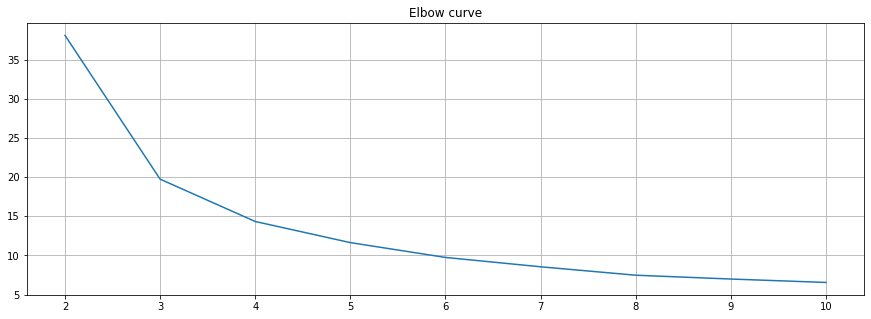

In [200]:
distorsions = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_iris_X)
    distorsions.append(kmeans.inertia_ / data_iris_X.shape[1])

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 11), distorsions)
plt.xticks(range(2, 11))
plt.grid(True)
plt.title('Elbow curve')
plt.show()

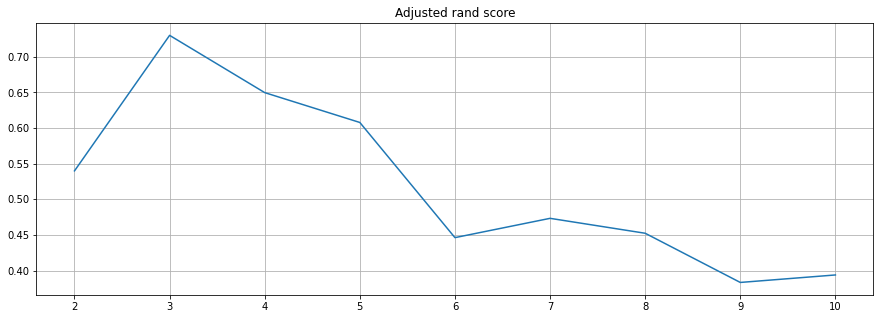

In [199]:
distorsions = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_iris_X)
    predictions = kmeans.labels_

    distorsions.append(adjusted_rand_score(data_iris_y, predictions))

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 11), distorsions)
plt.xticks(range(2, 11))
plt.grid(True)
plt.title('Adjusted rand score')
plt.show()

##Average linkage

For n_clusters = 2 The average silhouette_score is : 0.6863930543445408
For n_clusters = 3 The average silhouette_score is : 0.5539343898551252
For n_clusters = 4 The average silhouette_score is : 0.47166531675930684
For n_clusters = 5 The average silhouette_score is : 0.4303416822141368
For n_clusters = 6 The average silhouette_score is : 0.34065865237555976
For n_clusters = 7 The average silhouette_score is : 0.36941067750646717
For n_clusters = 8 The average silhouette_score is : 0.3645436084191249
For n_clusters = 9 The average silhouette_score is : 0.31677604290958056
For n_clusters = 10 The average silhouette_score is : 0.3083804867355036


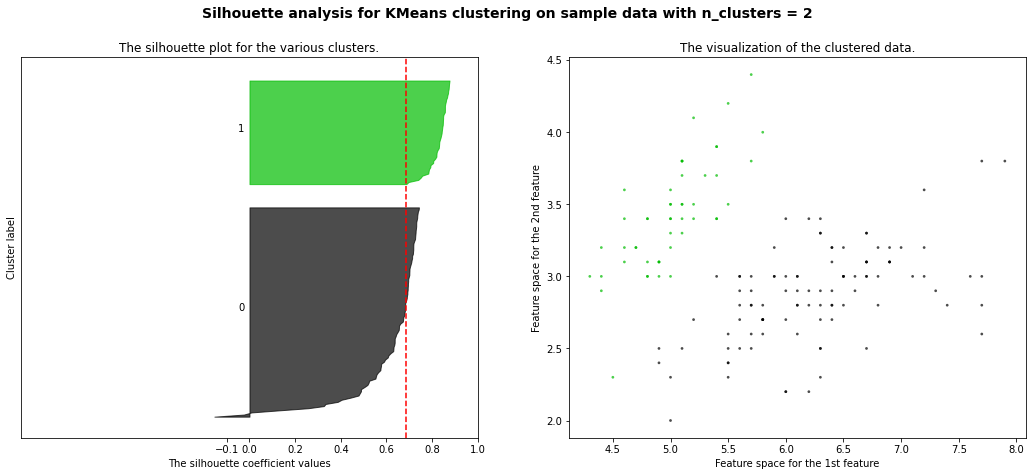

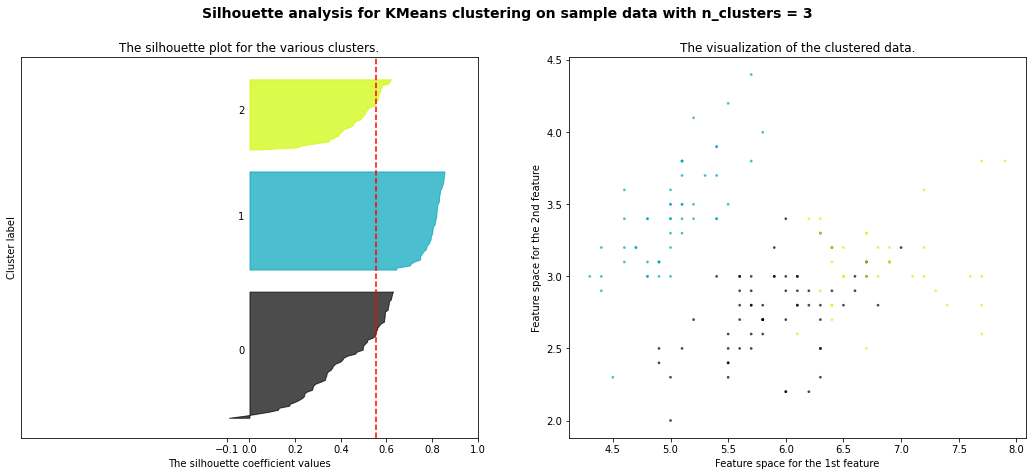

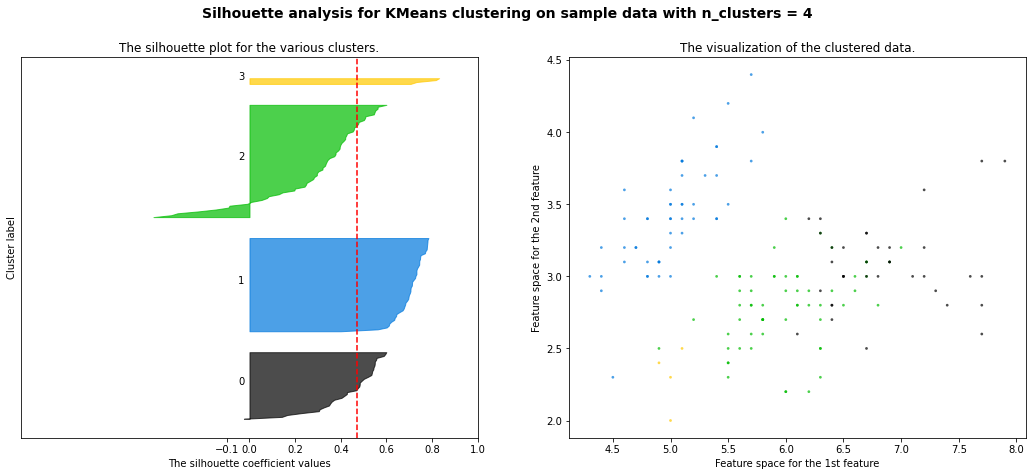

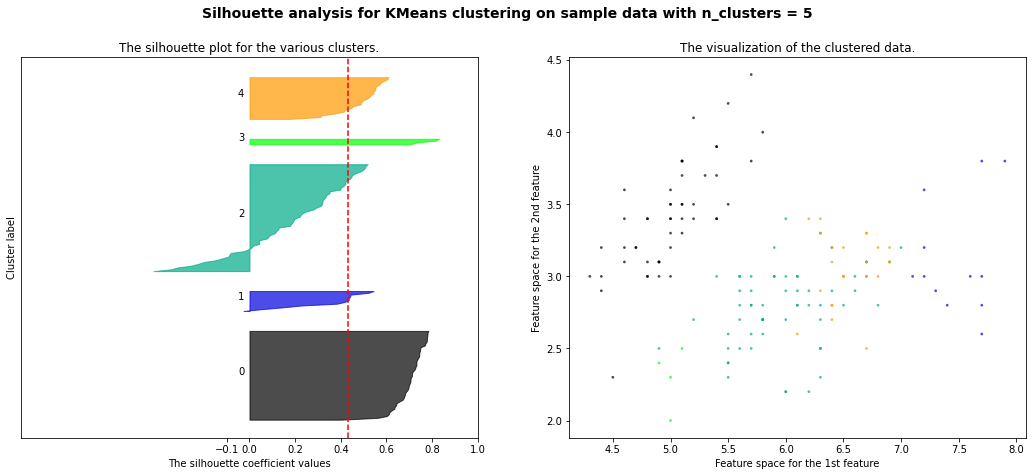

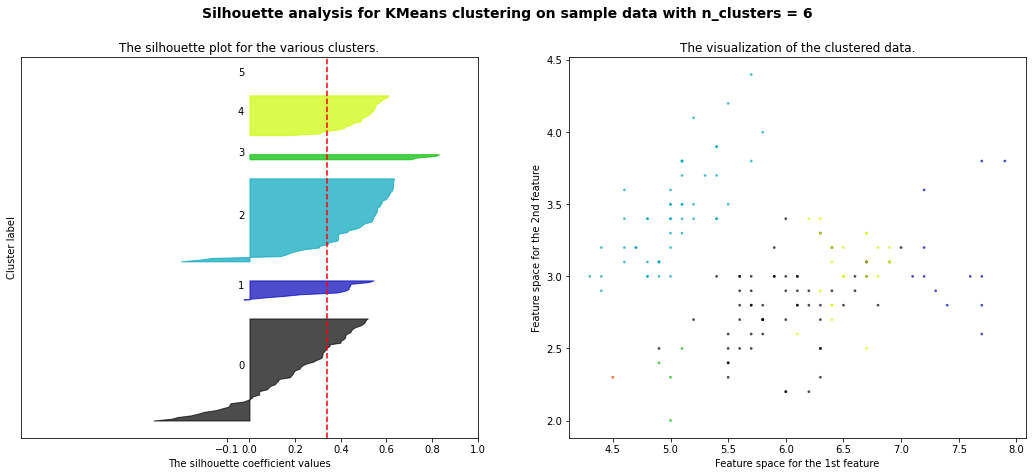

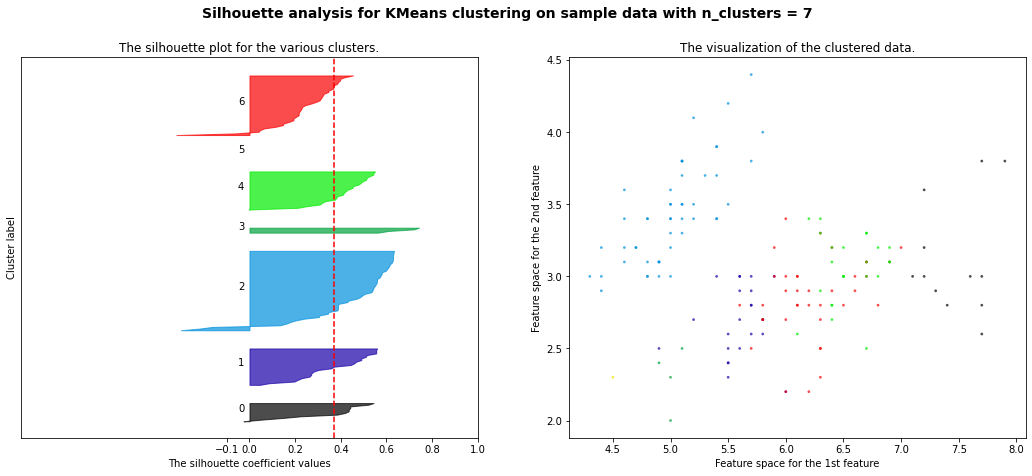

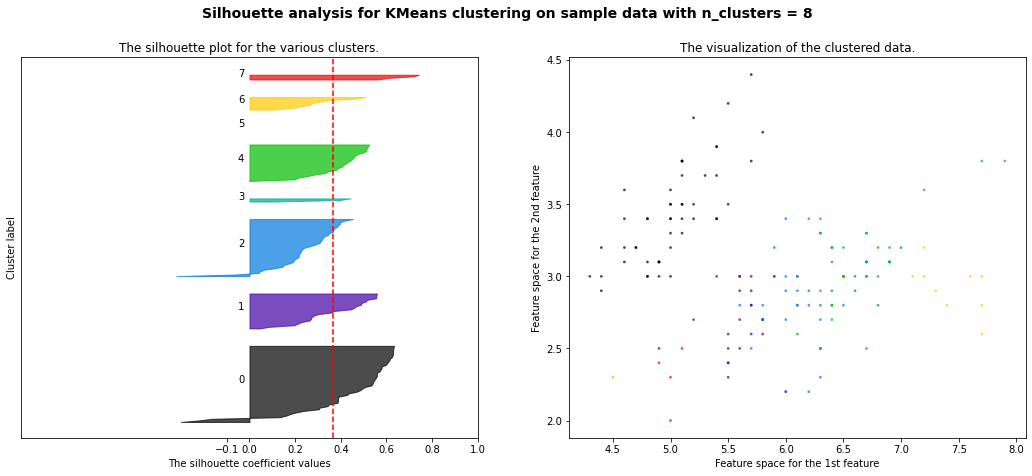

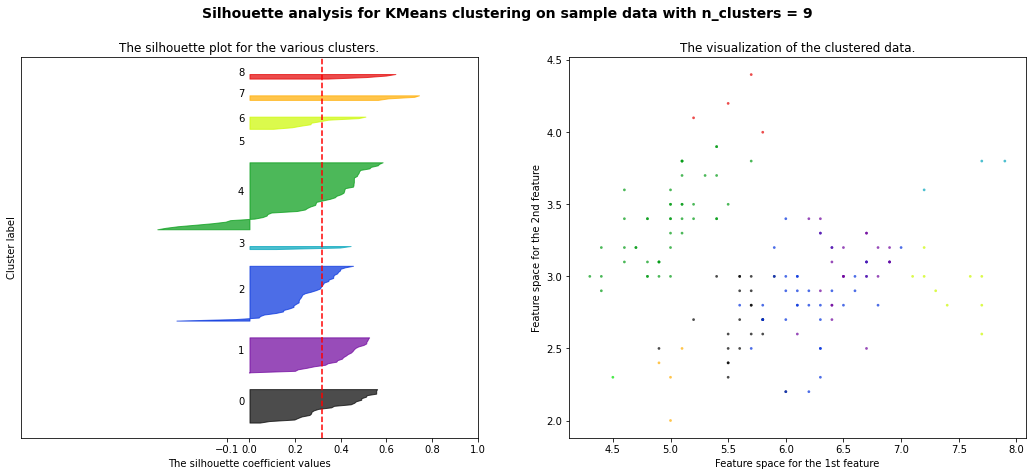

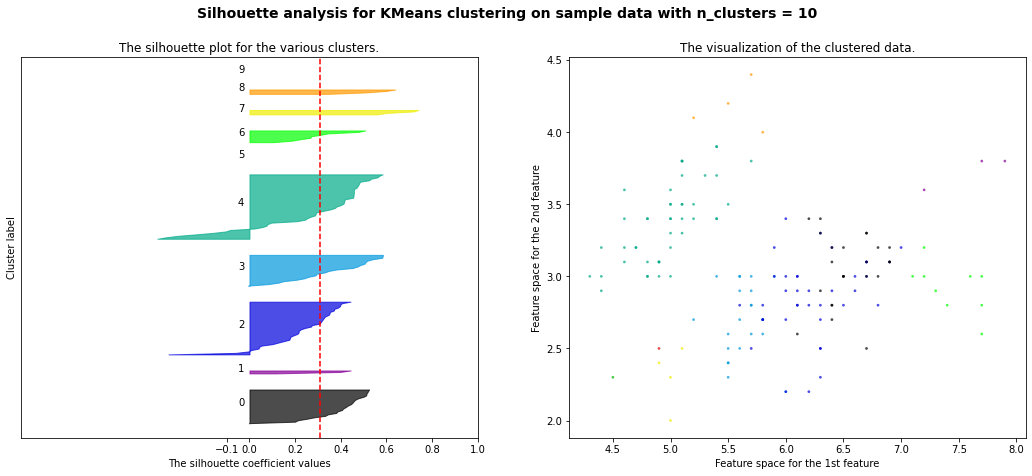

In [198]:
for n_clusters in range(2, 11):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(data_iris_X) + (n_clusters + 1) * 10])

    clusterer = AgglomerativeClustering(linkage='average', n_clusters=n_clusters).fit(data_iris_X)
    cluster_labels = clusterer.labels_

    silhouette_avg = silhouette_score(data_iris_X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(data_iris_X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        data_iris_X[:, 0],
        data_iris_X[:, 1],
        marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

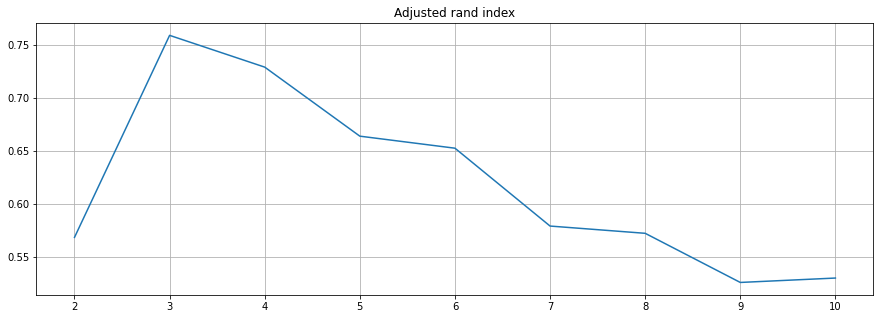

In [197]:
distorsions = []
for k in range(2, 11):
    averageLinkage = AgglomerativeClustering(linkage='average', n_clusters=k)
    averageLinkage.fit(data_iris_X)
    predictions = averageLinkage.labels_

    distorsions.append(adjusted_rand_score(data_iris_y, predictions))

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 11), distorsions)
plt.xticks(range(2, 11))
plt.grid(True)
plt.title('Adjusted rand index')
plt.show()

##Dendogram

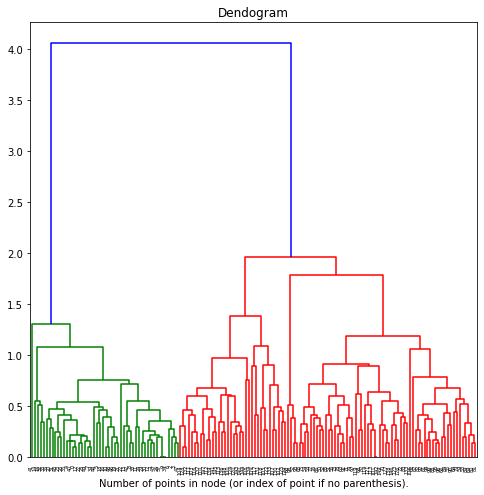

In [210]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

averageLinkage = AgglomerativeClustering(linkage='average', n_clusters=2, compute_distances=True)
averageLinkage = averageLinkage.fit(data_iris_X)
plt.figure(figsize=(8, 8))
plt.title(f"Dendogram")
plot_dendrogram(averageLinkage, truncate_mode="level")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

#Determining the optimal number of clusters on heart dataset

##KMeans

Adjusted rand index 2 clusters:  0.3867962148223543
Adjusted rand index 3 clusters:  0.2608992987661521
Adjusted rand index 4 clusters:  0.1891379292064363
Adjusted rand index 5 clusters:  0.19231034119845103
Adjusted rand index 6 clusters:  0.16346452145067147
Adjusted rand index 7 clusters:  0.12153815835272794
Adjusted rand index 8 clusters:  0.11181766770089618
Adjusted rand index 9 clusters:  0.10162732279287125
Adjusted rand index 10 clusters:  0.09627148211919576


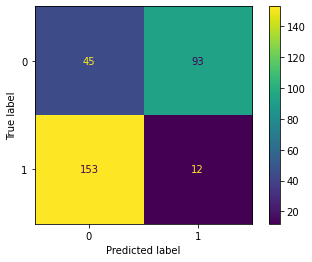

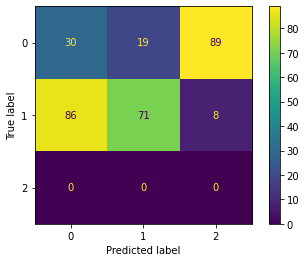

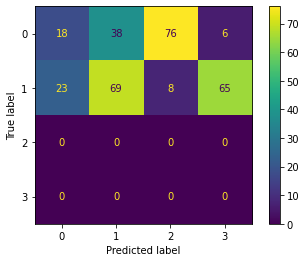

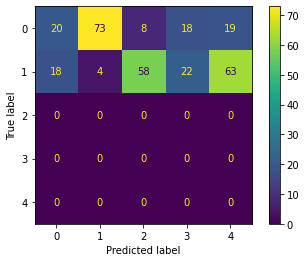

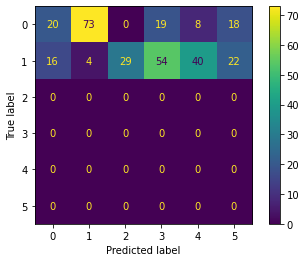

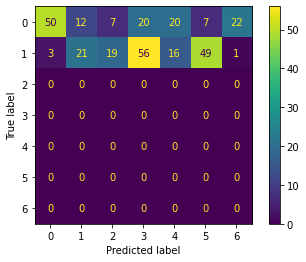

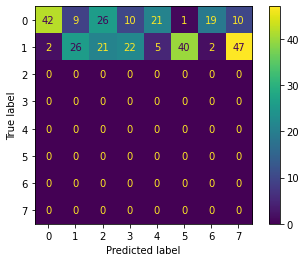

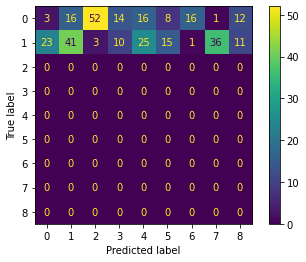

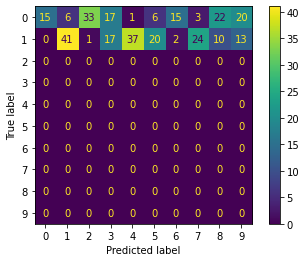

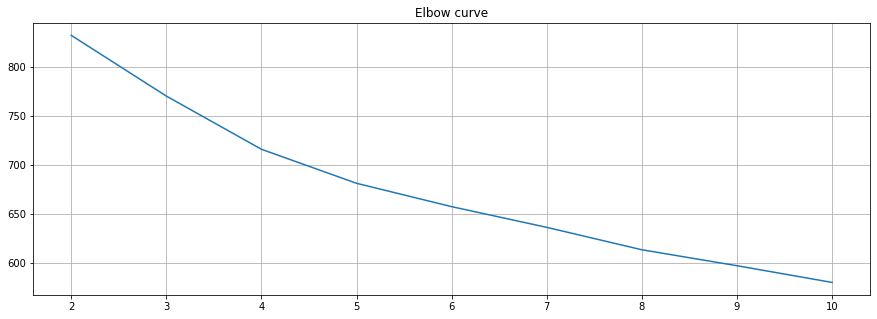

In [257]:
distorsions = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k).fit(data_heart_X_normalized)
    predictions = kmeans.labels_

    cm = confusion_matrix(data_heart_y, predictions)
    cmd = ConfusionMatrixDisplay(cm)
    cmd.plot()
    print(f"Adjusted rand index {k} clusters: ", adjusted_rand_score(data_y, predictions))

    distorsions.append(kmeans.inertia_ / data_iris_X.shape[1])

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 11), distorsions)
plt.xticks(range(2, 11))
plt.grid(True)
plt.title('Elbow curve')
plt.show()